In [1]:
# !git clone -b geral https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

Using device: cuda


'2.0.0+cu118'

### Customiza parametros da rede neural profunda equivariante

In [3]:
def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 10
    args.margin_loss = 2.0
    args.border  = 3
    args.exported = False
    return args

### Prepara dataloader transformado (preprocessamento)
- cria script de preprocessamento
- cria dataset e data load
- recupera o primeiro lote de dados

In [4]:
num_bin = 3
args = custom_config(args)
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)

In [5]:
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

10 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Carrega modelo e realiza a predição
- carrega modelo treinado (deteccao e orientacao)
- realiza predição
- aplica data argumentation sobre os dados de entrada e saida
- realiza predicao sobre os dados transformados

In [6]:
from training import KeyEqGroup, KeyPointsSelection, remove_borders, random_augmentation, shifted_batch_tensor
from utils import load_model, imshow, imshow2, imshow3,NMSHead
MODEL_PATH = "./data/models/model_flowers_ssim.pt"

model = load_model_trained(args,device,path=MODEL_PATH)

c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 39 loss 1.6361578539306043


In [7]:
_kp1, _orie1 = model(img_batch.to(device))
_kp1.shape,_orie1.shape,type(_kp1),type(_orie1)

(torch.Size([10, 1, 180, 180]),
 torch.Size([10, 36, 180, 180]),
 torch.Tensor,
 torch.Tensor)

In [8]:
points = torch.randn(img_batch.shape[0], 2,
                     2).to(device)  # BxNx2 [x,y] pontos sinteticos so pra completar parametros

#cria mascara para remocao de borda
_B, _C, _W, _H = img_batch.shape
SIZE_BORDER = args.border
batch_mask = torch.zeros(_B, 1, _W, _H).to(device)
batch_mask[:, :, SIZE_BORDER:_W - SIZE_BORDER, SIZE_BORDER:_H - SIZE_BORDER] = 1
# aplica dataaugmentation
batch_image_pos_trans, feature_kp_anchor_trans, features_ori_anchor_trans, coords_trans, mask_trans = random_augmentation(
    img_batch,
    _kp1, _orie1,
    points,
    batch_mask)
# calcula as saidas sobre os dados transformados
_kp2, _orie2 = model(batch_image_pos_trans.to(device))
_kp2.shape,_orie2.shape,type(_kp2),type(_orie2)

(torch.Size([10, 1, 180, 180]),
 torch.Size([10, 36, 180, 180]),
 torch.Tensor,
 torch.Tensor)

### Visualizar o resultado dos mapas de ativações:
#### - magnitude
#### - orientação (max entre todos os filtros de grupo)

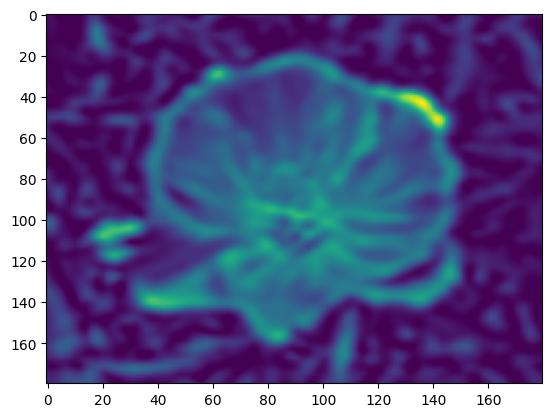

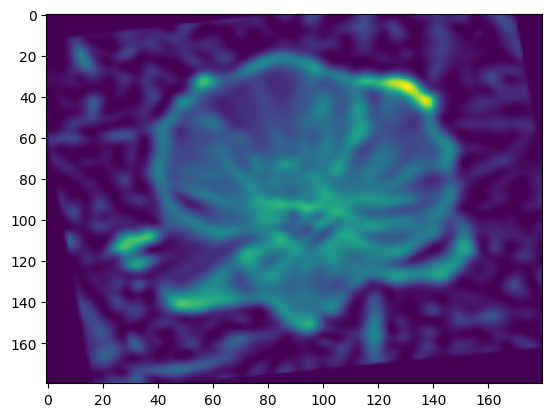

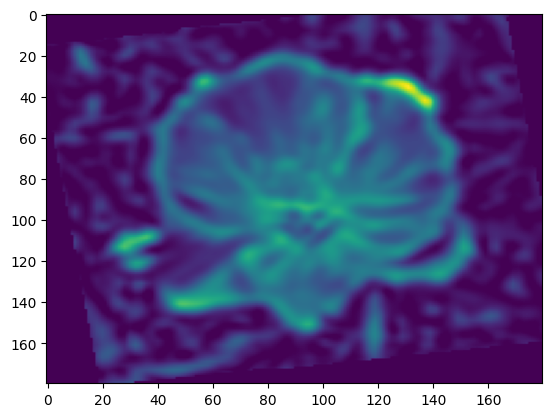

In [9]:
index = 5

plt.imshow(_kp1[index][0].cpu().detach(), aspect='auto')
plt.show()
plt.imshow(feature_kp_anchor_trans[index][0].cpu().detach(), aspect='auto')
plt.show()

_k2_mask=_kp2*mask_trans
plt.imshow(_k2_mask[index][0].cpu().detach(), aspect='auto')
plt.show()

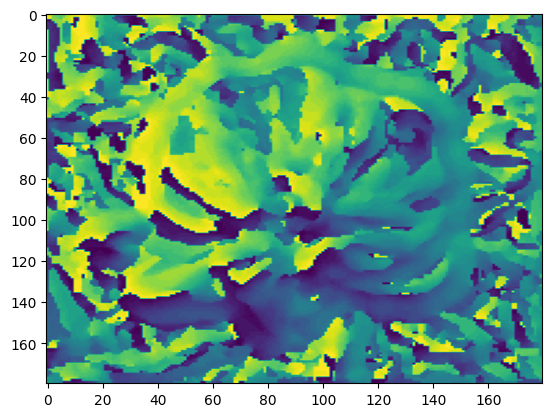

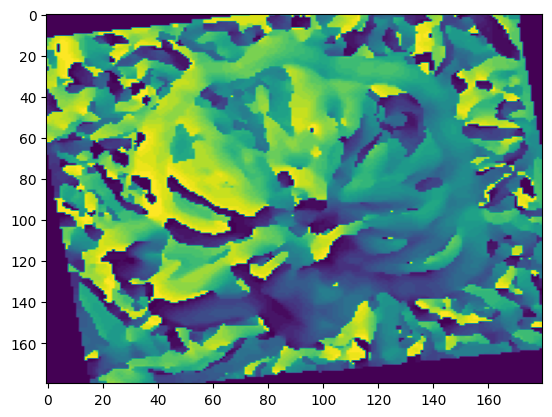

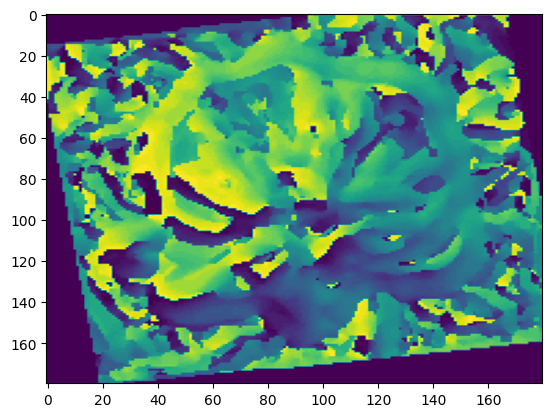

In [10]:
from predict import compute_gradient_direction

ori_arg_max= compute_gradient_direction(_orie1)
plt.imshow(ori_arg_max[index].cpu().detach(), aspect='auto')
plt.show()
features_ori_max= compute_gradient_direction(features_ori_anchor_trans)
plt.imshow(features_ori_max[index].cpu().detach(), aspect='auto')
plt.show()
_orie2_mask=_orie2*mask_trans
_ori2_arg_max= compute_gradient_direction(_orie2_mask)
plt.imshow(_ori2_arg_max[index].cpu().detach(), aspect='auto')
plt.show()

In [11]:
t =features_ori_max[index].cpu().detach()
print(t.shape,t[0,0],t[170,0],t.min(),t.max())

torch.Size([180, 180]) tensor(0.) tensor(0.) tensor(0.) tensor(350.)


### Computar um histograma que traz a magnitude x orientação

#### Somátorio da magnitude do gradiente no intervalo (bin) da direção
1. cria um filto (a) circular;
2. cria filtros (b) por intervalo da orientação sobre o mapa de ativação da orientação;
3. aplica a intercção entre os filtros (a) e (b) sobre o mapa de ativação da detecção;
4. realiza o somatorio dos itens filtrado e define como o valor do bin.
5. repete a partir do item 2 para cada bin do histograma.

180 180


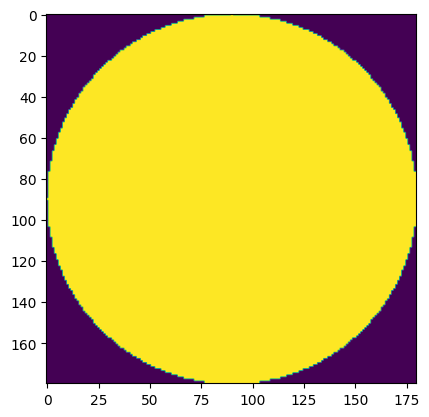

In [12]:
# filtro circular
from utils import create_circular_mask,create_circular_mask2,create_interval_mask,intersection_filter_interval_mask

circular_mask = create_circular_mask(_H,_W)
print(_H,_W)
plt.imshow(circular_mask)

((180, 180), (180, 180), numpy.ndarray, numpy.ndarray)

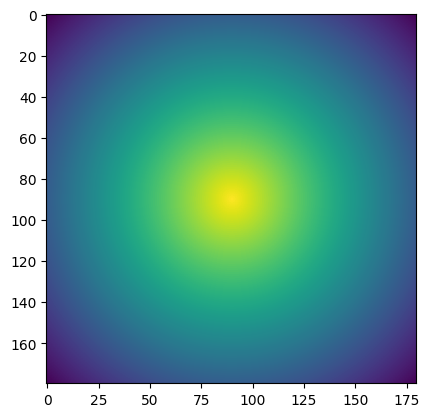

In [13]:
alternative_mask = create_circular_mask2(_H,_W)
plt.imshow(alternative_mask)
circular_mask.shape,alternative_mask.shape,type(circular_mask),type(alternative_mask)

torch.Size([10, 180, 180])


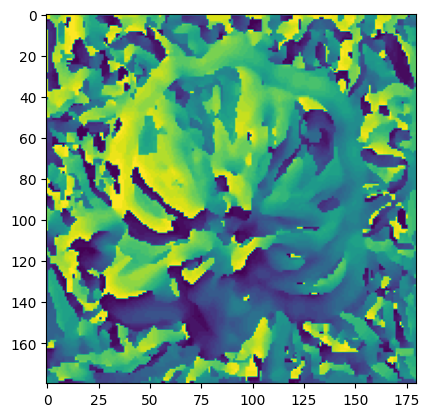

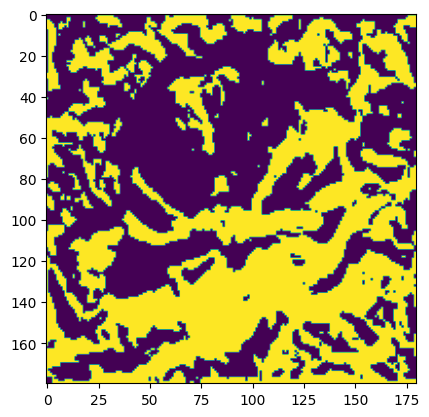

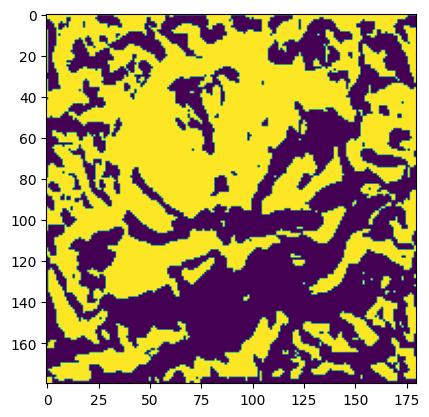

In [14]:
# filtros (b) por intervalo da orientação
print(ori_arg_max.shape)
plt.imshow(ori_arg_max[index].cpu().detach())
plt.show()

interval_mask = create_interval_mask(ori_arg_max,0,180)
plt.imshow(interval_mask[index].cpu().detach())
plt.show()

interval_mask2 = create_interval_mask(ori_arg_max,180,360)
plt.imshow(interval_mask2[index].cpu().detach())
plt.show()

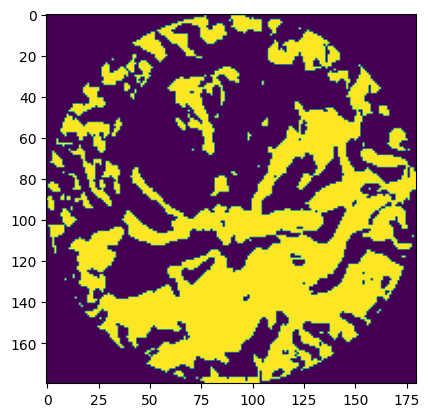

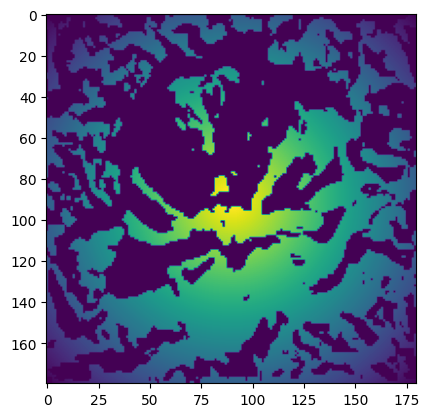

In [15]:
# aplicar intersecção entre os 2 filtros

mask_simples  = intersection_filter_interval_mask(interval_mask,torch.tensor(circular_mask[None]))
mask_alternative  = intersection_filter_interval_mask(interval_mask,torch.tensor(alternative_mask[None]))



plt.imshow(mask_simples[index].cpu().detach())
plt.show()


plt.imshow(mask_alternative[index].cpu().detach())
plt.show()

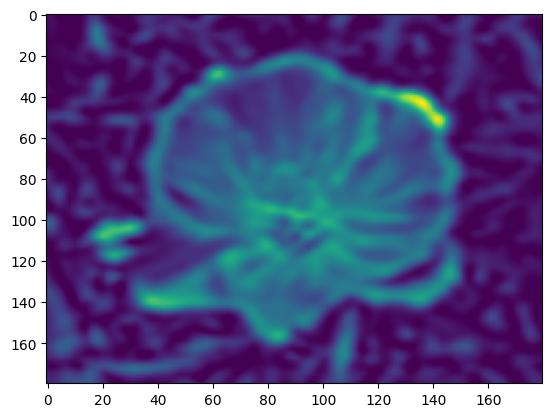

torch.Size([10, 1, 180, 180])


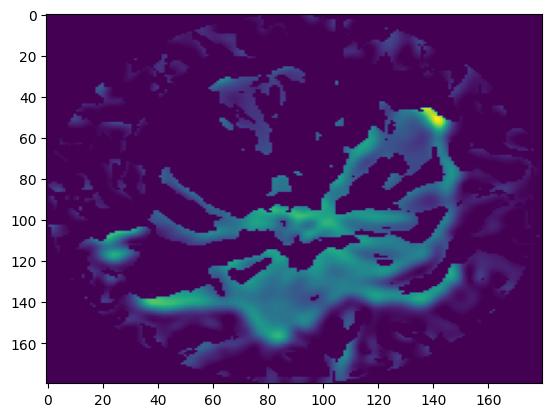

In [16]:
# computar somátorio entre os pixeis ativo pela filtragem
from utils import sum_filtered_intensity,build_histogram_orientation
plt.imshow(_kp1[index][0].cpu().detach(), aspect='auto')
plt.show()

sum_b, batch_filtered = sum_filtered_intensity(_kp1,mask_simples)
print(batch_filtered.shape)
plt.imshow(batch_filtered[index][0].cpu().detach(), aspect='auto')
plt.show()

#### Interar e construir um histograma com varios filtros de intervalo de bin

torch.Size([10, 180, 180]) torch.Size([10, 1, 180, 180])
tensor(0., device='cuda:0') tensor(350., device='cuda:0')
<class 'numpy.ndarray'> (180, 180)
interval : 0  -  120


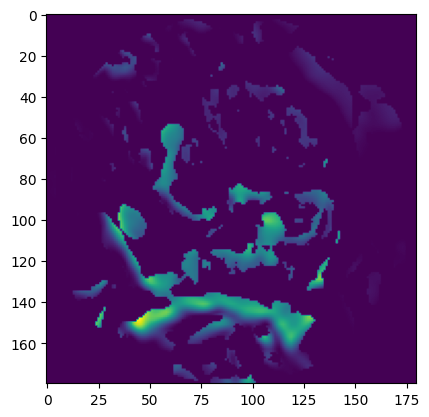

interval : 120  -  240


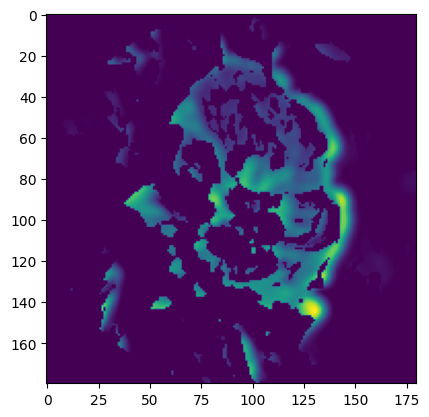

interval : 240  -  360


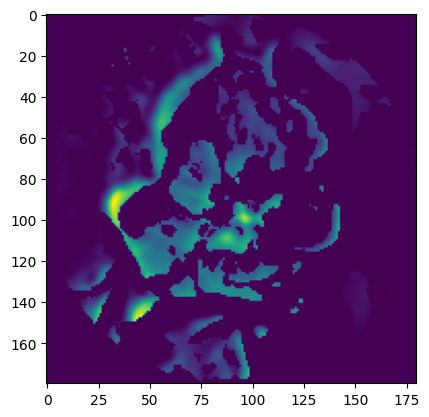

(torch.Size([10, 3]),
 tensor([[0.2613, 0.2913, 0.2866],
         [0.2068, 0.2366, 0.2417],
         [0.3729, 0.3108, 0.3460],
         [0.3486, 0.3957, 0.4683],
         [0.4437, 0.4474, 0.3835],
         [0.2196, 0.2174, 0.2235],
         [0.3303, 0.3252, 0.3218],
         [0.3506, 0.3298, 0.3269],
         [0.3816, 0.3744, 0.3311],
         [0.0751, 0.0633, 0.0584]], device='cuda:0', grad_fn=<DivBackward0>))

In [17]:
#Idealmente eu poderia passar um conjunto de features
#com a orientacao max e o seus mapas de ativacao e tamanho de bin
print(ori_arg_max.shape,_kp1.shape)
hist1_b = build_histogram_orientation(ori_arg_max,_kp1,circular_mask,num_bin,show=True)
hist1_b.shape,hist1_b

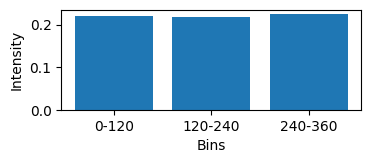

In [18]:
# funcao para exibir grafico de histograma com labels
def plot_histogram(hist):
    fig = plt.figure(figsize=(3,1))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(np.arange(len(hist)),hist)
    #colocar labels
    n_bin = len(hist)
    angle = 360/n_bin
    labels = ["{}-{}".format(int(i*angle),int((i+1)*angle)) for i in range(n_bin)]
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(labels)
    #titulo nos eixos
    ax.set_xlabel('Bins')
    ax.set_ylabel('Intensity')
    plt.show()


# def plot_histogram(hist):
#     fig = plt.figure(figsize=(3,1))
#     ax = fig.add_axes([0,0,1,1])
#     ax.bar(np.arange(len(hist)),hist)
#     plt.show()


plot_histogram(hist1_b[index].cpu().detach())

### Aplicar o shift dos bin do histograma de modo que o mesmo fique sempre numa mesma posição
- determinar a posição do bin de maior valor 
- realizar o movimento de shift numa determinada direção
- armazena os movimentos
- normaliza o histograma

In [19]:
# realiza shift no histograma de maneira controlada

In [20]:
# normaliza o histograma


### Commentarios
---
Em suma para realização da correspondencia de imagem utilizamos uma estratégia semelhante ao histograma orientado a gradiente aplicado a redes neurais profunda equivalirante a rotação, onde campo de atuação do histograma esta restrito a uma mascara circular.
Dentro da analise do histograma global temos ainda que o maior bin pode ajudar no alinhamento da imagem para encontramos um padrão.

### Testando os matching entre as caracteristicas

- Ja calculamos os histogramas das caracteristicas originais acima
- Calcularemos os histogramas as caracteristicas transformadas
- Nesse exemplo cada imagem representa uma caracteristica, porém no algoritmo final será uma sub-imagem
- Todos os histogramas serão normalizados entre o batch
- compararemos os histogramas original com os transformados para encontrar a correspondencia

torch.Size([10, 1, 180, 180]) torch.Size([10, 36, 180, 180])
tensor(0., device='cuda:0') tensor(350., device='cuda:0')
<class 'numpy.ndarray'> (180, 180)
interval : 0  -  120


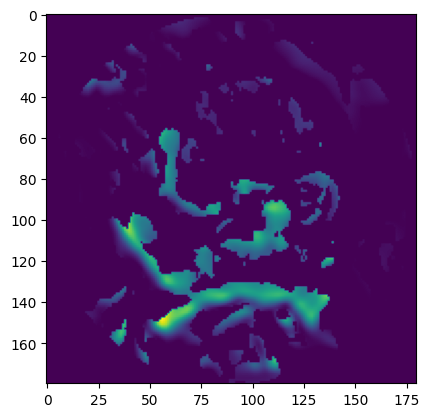

interval : 120  -  240


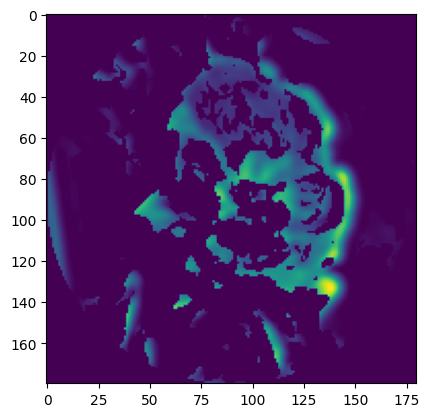

interval : 240  -  360


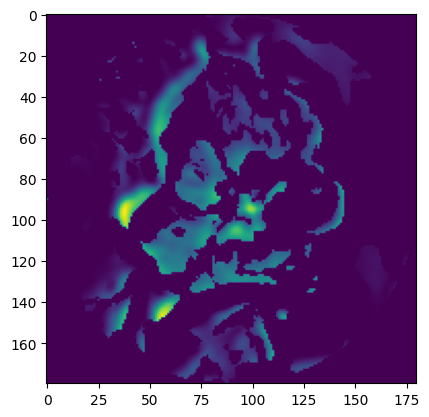

tensor([[0.2659, 0.3017, 0.2752],
        [0.2170, 0.2407, 0.2314],
        [0.3794, 0.3098, 0.3398],
        [0.3508, 0.3828, 0.4682],
        [0.4381, 0.4489, 0.4006],
        [0.2093, 0.2193, 0.2248],
        [0.3214, 0.3203, 0.3259],
        [0.3539, 0.3261, 0.3243],
        [0.3818, 0.3807, 0.3299],
        [0.0721, 0.0714, 0.0694]], device='cuda:0', grad_fn=<DivBackward0>)

In [21]:
print(_kp2.shape, _orie2.shape)
ori2_org_max= compute_gradient_direction(_orie2)
hist2_b = build_histogram_orientation(ori2_org_max,_kp2,circular_mask,num_bin,show=True)
hist2_b

In [22]:
print(hist1_b)
print(hist2_b)
for i in range(10):
    d=abs(hist2_b - hist1_b[i])
    diff_hist =torch.sum(d,(1))
    print("index: ",i," found in ",diff_hist.argmin().item()," position ")

tensor([[0.2613, 0.2913, 0.2866],
        [0.2068, 0.2366, 0.2417],
        [0.3729, 0.3108, 0.3460],
        [0.3486, 0.3957, 0.4683],
        [0.4437, 0.4474, 0.3835],
        [0.2196, 0.2174, 0.2235],
        [0.3303, 0.3252, 0.3218],
        [0.3506, 0.3298, 0.3269],
        [0.3816, 0.3744, 0.3311],
        [0.0751, 0.0633, 0.0584]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.2659, 0.3017, 0.2752],
        [0.2170, 0.2407, 0.2314],
        [0.3794, 0.3098, 0.3398],
        [0.3508, 0.3828, 0.4682],
        [0.4381, 0.4489, 0.4006],
        [0.2093, 0.2193, 0.2248],
        [0.3214, 0.3203, 0.3259],
        [0.3539, 0.3261, 0.3243],
        [0.3818, 0.3807, 0.3299],
        [0.0721, 0.0714, 0.0694]], device='cuda:0', grad_fn=<DivBackward0>)
index:  0  found in  0  position 
index:  1  found in  1  position 
index:  2  found in  2  position 
index:  3  found in  3  position 
index:  4  found in  4  position 
index:  5  found in  5  position 
index:  6  found in  6  position

### Teste com copilot

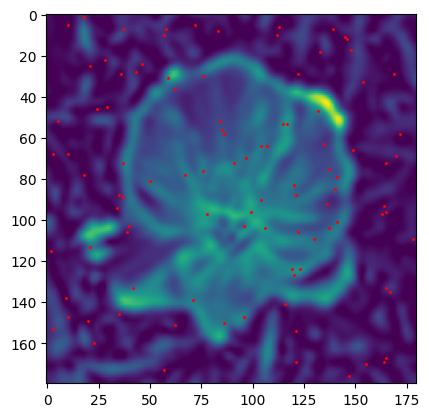

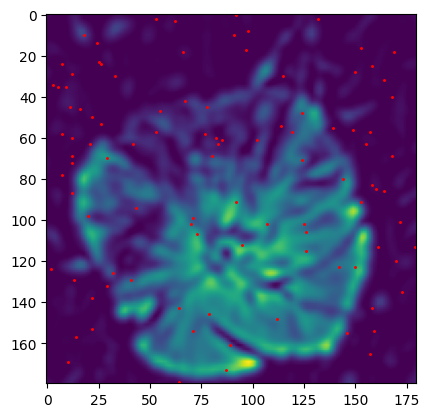

(100, 100)
torch.return_types.min(
values=tensor([ 4.2426, 10.0000,  6.0000, 14.4222, 10.1980,  4.4721,  7.8102,  8.0623,
         8.0623,  8.0623, 12.0416, 12.6491,  4.0000,  4.4721, 15.8114, 14.1421,
         9.2195,  9.0000,  9.0554,  8.0623, 11.4018,  8.6023,  3.6056,  8.4853,
         3.1623,  8.2462,  7.2801,  4.1231,  9.0554, 15.6205,  5.0000,  7.8102,
         8.2462, 10.1980,  5.0990,  9.0000,  9.4868, 13.6015, 15.0000, 14.7648,
         9.0000, 11.7047,  8.6023,  8.0623,  2.8284, 14.3178, 10.2956, 10.8167,
         2.0000,  9.4340, 13.4164, 11.4018,  2.2361,  1.4142,  6.7082,  8.0623,
         8.2462,  8.2462,  8.2462,  5.8310, 15.6525,  6.3246,  4.1231,  8.6023,
         3.1623,  5.3852, 11.7047, 15.1327,  8.6023, 15.0333,  7.0711,  7.0711,
        12.6491,  4.4721,  6.4031,  9.8489,  8.9443,  8.5440, 11.1803,  7.0000,
         2.2361,  5.0000, 14.5602, 10.7703,  8.2462, 22.8473,  3.1623,  8.0623,
         5.8310,  5.6569, 14.7648,  6.4031, 16.0312,  9.4868, 14.8661,  8.6023

In [23]:
def plot_image_with_keypoints(img,coordinates):
    plt.imshow(img)
    plt.scatter(coordinates[:, 1], coordinates[:, 0], s=5, marker='.', c='r')
    plt.show()

#gerar coordenadas aleatorias e exibir na tela
def generate_random_coordinates(img):
    coordinates = np.random.randint(0, img.shape[0], size=(100, 2))
    return coordinates

pt2 = generate_random_coordinates(_kp1[index][0].cpu().detach())
plot_image_with_keypoints(_kp1[index][0].cpu().detach(),pt2)
pt3 = generate_random_coordinates(_kp1[index][0].cpu().detach())
plot_image_with_keypoints(_kp1[index+1][0].cpu().detach(),pt3)

# calcular correspondencia entre os pontos de interesse pt2 e pt3 sua vizinhaça
def compute_correspondence(pt2,pt3):
    from scipy.spatial import distance_matrix
    dist = distance_matrix(pt2,pt3)
    return dist

dist = compute_correspondence(pt2,pt3)
print(dist.shape)
# mapear os index de correspondencia entre pt2 e pt3 com base na distancia
def map_correspondence(dist):
    dist = torch.tensor(dist)
    min_dist = torch.min(dist,1)
    return min_dist

min_dist = map_correspondence(dist)
print(min_dist)



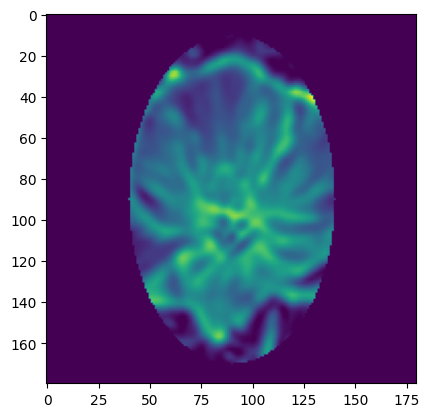

torch.Size([10, 1, 180, 180])

In [24]:
import numpy as np

def gerar_mascara_eliptica(imagem, centro, raio_x, raio_y):
    # Cria uma matriz de zeros com as mesmas dimensões da imagem
    mascara = np.zeros_like(imagem)

    # Obtém as dimensões da imagem
    altura, largura = imagem.shape[:2]

    # Cria uma grade de coordenadas x e y
    y, x = np.ogrid[:altura, :largura]

    # Calcula a distância entre cada ponto da grade e o centro da elipse
    distancia = ((x - centro[0]) / raio_x) ** 2 + ((y - centro[1]) / raio_y) ** 2

    # Define a máscara como 1 para os pontos dentro da elipse
    mascara[distancia <= 1] = 1

    # Aplica a máscara na imagem original
    imagem_mascarada = imagem * mascara

    return imagem_mascarada


W,H = _kp1[index][0].shape
_mask =gerar_mascara_eliptica(_kp1[index][0].cpu().detach(),(W//2,H//2),50,80)
plt.imshow(_mask)
plt.show()

_kp1.shape

In [25]:
_kp1[index][0].shape

torch.Size([180, 180])